In [1]:
# set to true to recompute BP positions from raw data

recompute = False

---

In [2]:
import micromagneticdata as mdata
import discretisedfield as df
import os
import pandas as pd
import ast
from multiprocessing import Pool
import matplotlib.pyplot as plt
import numpy as np
import itertools
from matplotlib.patches import ArrowStyle

In [3]:
if recompute:
    def pp(field):
        field.valid = 'norm'
        field.array[~field.valid] = float('nan')
        return field.orientation.sel(z=-1e-9).z

    data_left_hh = mdata.Data(name='mbp_l_600_w_100_ht_10_ixx')
    data_left_hh.info

    (data_left_hh[7] << data_left_hh[8] << data_left_hh[9] << data_left_hh[10]).register_callback(pp).hv(kdims=['x', 'y'])

In [4]:
geometry = df.Field.from_file('geometry.omf')
geometry.valid = 'norm'

In [5]:
if recompute:
    def loc_bp(filename):
        m = df.Field.from_file(filename)
        m.valid = geometry.valid
        pos_x = ast.literal_eval(df.tools.count_bps(m)['bp_pattern_x'])[0][1] * 2.5
        pos_y = ast.literal_eval(df.tools.count_bps(m, direction='y')['bp_pattern_y'])[0][1] * 2.5
        return pos_x, pos_y

    with Pool(len(os.sched_getaffinity(0))) as p:
        segment_1 = p.map(loc_bp, (data_left_hh[4] << data_left_hh[5] << data_left_hh[6])._step_files)

    with Pool(len(os.sched_getaffinity(0))) as p:
        segment_2 = p.map(loc_bp, (data_left_hh[7] << data_left_hh[8] << data_left_hh[9])._step_files)

    with Pool(len(os.sched_getaffinity(0))) as p:
        segment_3 = p.map(loc_bp, (data_left_hh[10] << data_left_hh[11] << data_left_hh[12])._step_files)

    pd.DataFrame({'t': (data_left_hh[4] << data_left_hh[5] <<  data_left_hh[6]).table.data['t'], 'pos_x': np.array(segment_1)[:, 0], 'pos_y': np.array(segment_1)[:, 1]}).to_csv('segment_1.csv', index=False)

    pd.DataFrame({'t': (data_left_hh[7] << data_left_hh[8] <<  data_left_hh[9]).table.data['t'], 'pos_x': np.array(segment_2)[:, 0], 'pos_y': np.array(segment_2)[:, 1]}).to_csv('segment_2.csv', index=False)

    pd.DataFrame({'t': (data_left_hh[10] << data_left_hh[11] <<  data_left_hh[12]).table.data['t'], 'pos_x': np.array(segment_3)[:, 0], 'pos_y': np.array(segment_3)[:, 1]}).to_csv('segment_3.csv', index=False)
else:
    segment_1 = pd.read_csv('segment_1.csv')[['pos_x', 'pos_y']].to_numpy()
    segment_2 = pd.read_csv('segment_2.csv')[['pos_x', 'pos_y']].to_numpy()
    segment_3 = pd.read_csv('segment_3.csv')[['pos_x', 'pos_y']].to_numpy()

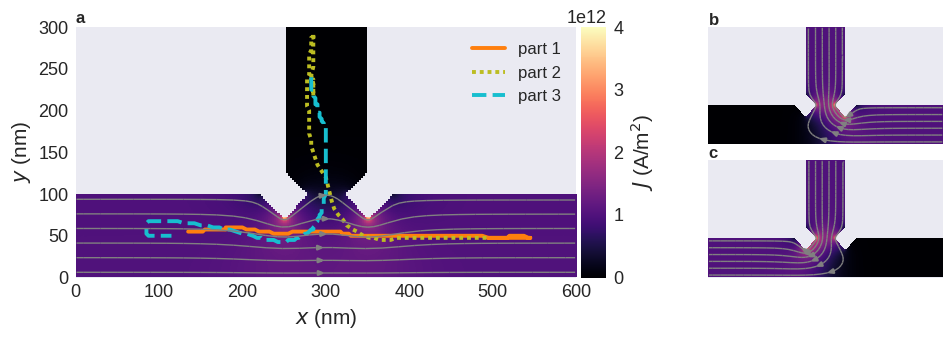

In [6]:
mosaic = """
ab
ac
"""
fig, axs = plt.subplot_mosaic(mosaic, figsize=(10, 3.5), layout='tight', gridspec_kw={"width_ratios": (2.5, 1)})

ax = axs["a"]
j_profile = df.Field.from_file('current-left-right.omf')
j_profile.valid = geometry.valid
j_profile.sel('z').norm.mpl.scalar(ax=ax, cmap='magma', colorbar_label=r'$J$ (A/m$^2$)', clim=(0, 4e12))

for i, (segment, linestyle, c) in enumerate([(segment_1, '-', 'tab:orange'), (segment_2, (0, (1, 1)), 'tab:olive'), (segment_3, '--', 'tab:cyan')], start=1):
    line, = ax.plot(np.array(segment)[:,0], np.array(segment)[:,1], linestyle=linestyle, label=f'part {i}', c=c, linewidth=2.8)
    
ax.legend()

start = 2
step = 7
sp = ax.streamplot(
    j_profile.mesh.points.x, j_profile.mesh.points.y,
    j_profile.sel('z').x.array.squeeze().T, j_profile.sel('z').y.array.squeeze().T,
    start_points=list(zip(itertools.repeat(10), j_profile.mesh.points.y[start::step])),
    color='grey', broken_streamlines=False, arrowstyle=ArrowStyle.Simple(tail_width=0.01, head_width=0.25, head_length=0.3)
)
sp.lines.set_linewidth(1)

ax.set_xlabel('$x$ (nm)')
ax.set_ylabel('$y$ (nm)')
    

ax = axs["b"]
j_profile = df.Field.from_file('current-top-right.omf')
j_profile.valid = geometry.valid
j_profile.sel('z').norm.mpl.scalar(ax=ax, cmap='magma', colorbar=False, clim=(0, 4e12))

start_x = 2
step = 7
sp = ax.streamplot(
    j_profile.mesh.points.x, j_profile.mesh.points.y,
    j_profile.sel('z').x.array.squeeze().T*-1, j_profile.sel('z').y.array.squeeze().T*-1,
    start_points=list(zip(itertools.repeat(590), j_profile.mesh.points.y[start::step])),
    color='grey', broken_streamlines=False, arrowstyle=ArrowStyle.Simple(tail_width=0.01, head_width=0.25, head_length=0.3)
)
sp.lines.set_linewidth(1)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')


ax = axs["c"]
j_profile = df.Field.from_file('current-left-top.omf')
j_profile.valid = geometry.valid
j_profile.sel('z').norm.mpl.scalar(ax=ax, cmap='magma', colorbar=False, clim=(0, 4e12))

start = 2
step = 7
sp = ax.streamplot(
    j_profile.mesh.points.x, j_profile.mesh.points.y,
    j_profile.sel('z').x.array.squeeze().T*-1, j_profile.sel('z').y.array.squeeze().T*-1,
    start_points=list(zip(itertools.repeat(10), j_profile.mesh.points.y[start::step])),
    color='grey', broken_streamlines=False, arrowstyle=ArrowStyle.Simple(tail_width=0.01, head_width=0.25, head_length=0.3)
)
sp.lines.set_linewidth(1)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')


for label in "abc":
    axs[label].text(0, 305, label, fontweight='bold', fontsize='large')

In [ ]:
fig.savefig('Fig7.pdf')